In [1]:
import pandas as pd
import numpy as np
import processing.scales as scales
import os

# define variable names
tia_scales = scales.tia_scales
hcsds_scales = scales.hcsds_scales
ati_scales = scales.ati_scales
manip_check_scales = scales.manip_check_scales

scale_titles = scales.scale_titles

# Create output and plot directories if they don't exist
plots_path = '../plots/univariate_analysis/'
os.makedirs(plots_path, exist_ok=True)

output_path = '../output/'
os.makedirs(output_path, exist_ok=True)

# Load data
data = pd.read_csv('../data/data_scales.csv')
print(f"Total sample size: {len(data)}")
print(f"\nGroup distribution:")
print(data['stimulus_group'].value_counts())
print('\n')

# compute basic statistics for later tests
N = len(data)
p = len(tia_scales)
k = data['stimulus_group'].nunique()

# set alpha and power
alpha = 0.05
power = 0.80

print(f'Sample size: N = {N}')
print(f'Number of outcomes: p = {p}')
print(f'Number of groups: k = {k}')

Total sample size: 255

Group distribution:
stimulus_group
1    129
0    126
Name: count, dtype: int64


Sample size: N = 255
Number of outcomes: p = 5
Number of groups: k = 2


## Data Preparation

### Variable Centering and Coding

We prepare variables for moderation analysis:

1. **Effect code treatment**: stimulus_group as -0.5 (control) and 0.5 (uncertainty)
2. **Standardize continuous variables**: For better comparison of beta values between variables
3. **Effect code categorical variables**: For symmetric interpretation

In [2]:
# 1. Effect code treatment: control = -0.5, uncertainty = 0.5
data['group_effect'] = data['stimulus_group'] - 0.5

# 2. Normalize all continuous variables
continuous_vars = hcsds_scales + ati_scales + ['age', 'page_submit']

for var in continuous_vars:
    data[f'{var}_c'] = (data[var] - data[var].mean())/data[var].std()

# 3. Effect code gender: male (1) = 0.5, female (2) = -0.5, "other/prefer not to say" (3) = 0
data['gender_c'] = data['gender'].map({1: 0.5, 2: -0.5, 3: 0})

# 4. Mean-center ordinal variables (education, AI experience)
data['education_c'] = data['education'] - data['education'].mean()
data['ai_exp_c'] = data['Q19'] - data['Q19'].mean()
data.drop('Q19', axis=1)

demographics = ['age', 'gender', 'education', 'ai_exp']

demographics_c = [f'{s}_c' for s in demographics]
hcsds_scales_c = [f'{s}_c' for s in hcsds_scales]
ati_scales_c = [f'{s}_c' for s in ati_scales]

print(f"Prepared {len(data)} observations for analysis")
print(f"Continuous moderators: {len(continuous_vars)}")
print(f"Total moderators to test: {len(continuous_vars) + 3}")  # + gender, education, Q19

Prepared 255 observations for analysis
Continuous moderators: 5
Total moderators to test: 8


## ANOVA Models Selection

In [3]:
# make strings for list of predictors in each model
model_predictors = []
model_predictors.append(['group_effect'])
model_predictors.append(model_predictors[0] + demographics_c)
model_predictors.append(model_predictors[1] + hcsds_scales_c + ati_scales_c)

interactions = [f'group_effect:{p}' for p in demographics_c + hcsds_scales_c + ati_scales_c]

model_predictors.append(model_predictors[2] + interactions)

# build models for each tia_subscale separately
import statsmodels.formula.api as smf

results = {}
for subscale in tia_scales:
    results[subscale] = {}
    for model_nr, predictors in enumerate(model_predictors):
        formula = f'{subscale} ~ {' + '.join(predictors)}'
        result = smf.ols(formula, data=data).fit()

        print(f'Predicting {subscale} in model {model_nr+1}')
        print(result.summary())
        print(f'{'='*20}\n\n')

        results[subscale][model_nr+1] = result

Predicting tia_f in model 1
                            OLS Regression Results                            
Dep. Variable:                  tia_f   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.675
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.197
Time:                        17:59:32   Log-Likelihood:                -338.80
No. Observations:                 255   AIC:                             681.6
Df Residuals:                     253   BIC:                             688.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1

### Conclusion Model Selection
Select full model, unless I get other information from SMAP.

In [14]:
SELECT_MODEL = 4
CORRECTION_METHOD = "holm"
################################

result_tables = {}
model_stats = {}

# save results to tables
for subscale in tia_scales:
    result = results[subscale][SELECT_MODEL]
    df = pd.DataFrame(result.summary().tables[1])
    df.iloc[0, 0] = 'predictor'
    df.columns = ['predictor', 'coef', 'se', 't', 'p', 'CI_lower', 'CI_higher']
    df = df[1:]

    result_tables[subscale] = df

    # save to file
    df.to_csv(f'{output_path}{subscale}_regression_coef.csv', index=False)

    # save model stats for later
    model_stats[subscale] = {
        'r_squared': result.rsquared,
        'adj_r_squared': result.rsquared_adj,
        'F': result.fvalue,
        'p_for_F': result.f_pvalue,
        'df_model': result.df_model,
        'df_resid': result.df_resid
    }

model_stats_table = pd.DataFrame(model_stats)
model_stats_table.to_csv(f'{output_path}regression_model_stats.csv', index=True)
print(model_stats_table)

'''
Somehow, the `tables` object from `statsmodels` gives values as a `Cell` object instead of just numbers.
It's easiest to just save everything to a file and then read it again (very stupid, I know).
'''

# correct p-values for multiple comparisons
from statsmodels.stats.multitest import multipletests
from scripts.utils import apa_p

def convert_to_partial_eta_sq(t, df_resid):
    return t**2 / (t**2 + df_resid)

for subscale in tia_scales:
    result_table = pd.read_csv(f'{output_path}{subscale}_regression_coef.csv')

    if CORRECTION_METHOD.lower() == 'none':
        result_table['p_adj'] = result_table['p'].copy()
    else:
        result_table['p_adj'] = multipletests(result_table['p'],
                                        alpha=alpha,
                                        method=CORRECTION_METHOD)[1]

    p_adj_report = []
    partial_eta_sq = []
    for i, row in result_table.iterrows():
        p_adj_report.append(apa_p(row['p_adj'],
                                    sig_stars=True))
        partial_eta_sq.append(convert_to_partial_eta_sq(row['t'], model_stats[subscale]['df_resid']))

    result_table['partial_eta_sq'] = partial_eta_sq
    result_table['p_adj_report'] = p_adj_report

    # save to file, overwrite original csv file
    result_table.to_csv(f'{output_path}{subscale}_regression_coef.csv', index=False)

    # also save to memory, overwrite old version
    result_tables[subscale] = result_table


                    tia_f     tia_pro      tia_rc         tia_t      tia_up
r_squared        0.142950    0.158508    0.191100  2.457100e-01    0.071720
adj_r_squared    0.089160    0.105695    0.140332  1.983696e-01    0.013460
F                2.657561    3.001298    3.764189  5.190284e+00    1.231025
p_for_F          0.000949    0.000199    0.000006  6.270715e-09    0.249004
df_model        15.000000   15.000000   15.000000  1.500000e+01   15.000000
df_resid       239.000000  239.000000  239.000000  2.390000e+02  239.000000


## 5b. Univariate Non-Inferiority Test (ANOVA)

In [98]:
# find MDE (minimally detectable effect) in a ANOVA
from scipy import stats

def mde_regression(se, df_resid, alpha=0.05, power=0.80):
    """
    Minimally detectable effect for a regression coefficient.

    Parameters:
        se: standard error of the coefficient (from statsmodels)
        df_resid: residual degrees of freedom (model.df_resid)
        alpha: significance level (two-tailed)
        power: desired power

    Returns:
        MDE in original units of the coefficient
    """
    t_crit = stats.t.ppf(1 - alpha / 2, df_resid)  # two-tailed significance
    t_pow = stats.t.ppf(power, df_resid)           # power threshold
    return (t_crit + t_pow) * se

In [99]:
# calculate MDE (non-inferiority margin) for each DV using regression SE
ni_margin = {}

for subscale in tia_scales:
    res = result_tables[subscale]

    reg_se = res[res['predictor'] == 'group_effect'].iloc[0]['se']
    df = model_stats[subscale]['df_model']

    # MDE = (t_α/2 + t_β) × SE
    ni_margin[subscale] = mde_regression(reg_se, df, alpha=alpha, power=power)

print("Non-inferiority margins (MDE, as b-coefficients):")
for subscale in tia_scales:
    print(f"{subscale}:\n"
          f"  {ni_margin[subscale]:.3f}\n")

Non-inferiority margins (MDE, as b-coefficients):
tia_f:
  0.348

tia_pro:
  0.249

tia_rc:
  0.207

tia_t:
  0.282

tia_up:
  0.291




Non-Inferiority Test Results for 'TiA - Familiarity':
  Mean difference: M_diff = 0.175, SE = 0.116
  95% CI: [-0.0525, 0.4023]
  SESOI margin: -0.3477
  z = 4.505, p < .001
  Result: Non-inferiority established (p < .001)


Non-Inferiority Test Results for 'TiA - Propensity to Trust':
  Mean difference: M_diff = -0.040, SE = 0.083
  95% CI: [-0.2022, 0.1232]
  SESOI margin: -0.2488
  z = 2.522, p = .006
  Result: Non-inferiority established (p = .006)


Non-Inferiority Test Results for 'TiA - Reliability/Competence':
  Mean difference: M_diff = -0.096, SE = 0.069
  95% CI: [-0.2314, 0.0390]
  SESOI margin: -0.2068
  z = 1.603, p = .054
  Result: Non-inferiority not established (p = .054)


Non-Inferiority Test Results for 'TiA - Trust in Automation':
  Mean difference: M_diff = -0.101, SE = 0.094
  95% CI: [-0.2855, 0.0829]
  SESOI margin: -0.2818
  z = 1.920, p = .027
  Result: Non-inferiority not established (p = .027)


Non-Inferiority Test Results for 'TiA - Understanding/Predict

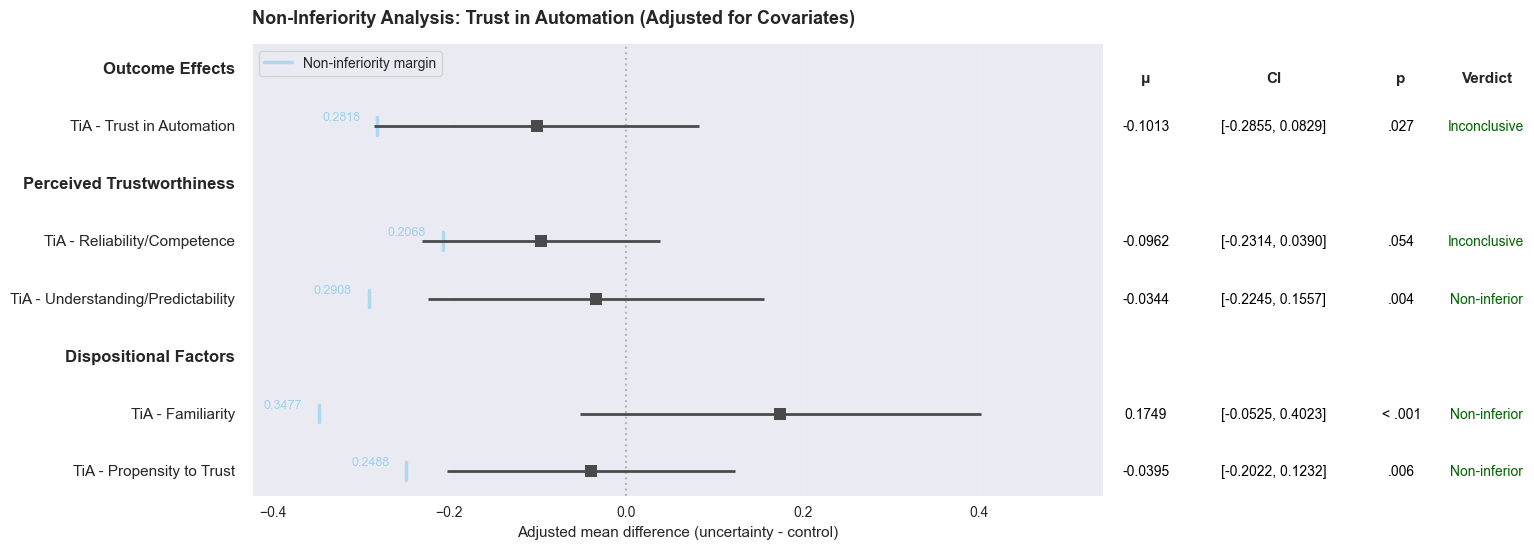

In [8]:
# Plot non-inferiority test
from scripts.viz_utils import plot_noninferiority_test
import matplotlib.pyplot as plt

coefficients = [result_tables[subscale][result_tables[subscale]['predictor'] == 'group_effect'].iloc[0]['coef'] for subscale in tia_scales]
ses = [result_tables[subscale][result_tables[subscale]['predictor'] == 'group_effect'].iloc[0]['se'] for subscale in tia_scales]

categories = {
    'Outcome Effects': ['tia_t'],
    'Perceived Trustworthiness': ['tia_rc', 'tia_up'],
    'Dispositional Factors': ['tia_f', 'tia_pro']
}

fig, ax = plt.subplots(figsize=(5, 25))
plot_noninferiority_test(
    effect_size=coefficients,
    sesoi=[ni_margin[subscale][0] for subscale in tia_scales],
    se=ses,
    alpha=alpha,
    variable_names=tia_scales,
    variable_labels=scale_titles,
    title='Non-Inferiority Analysis: Trust in Automation (Adjusted for Covariates)',
    xlabel='Adjusted mean difference (uncertainty - control)',
    categories=categories,
    category_order=['Outcome Effects', 'Perceived Trustworthiness', 'Dispositional Factors'],
    height_scale=0.7,
    column_title_pos_shift=-0.5,
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}univariate_noninferiority_test.png', dpi=150, transparent=True)
plt.show()

In [77]:
coef = result_tables['tia_f'][result_tables['tia_f']['predictor'] == 'age_c'].iloc[0]['coef']
se = result_tables['tia_f'][result_tables['tia_f']['predictor'] == 'age_c'].iloc[0]['se']
t = result_tables['tia_f'][result_tables['tia_f']['predictor'] == 'age_c'].iloc[0]['t']
ci_lower = result_tables['tia_f'][result_tables['tia_f']['predictor'] == 'age_c'].iloc[0]['CI_lower']
ci_higher = result_tables['tia_f'][result_tables['tia_f']['predictor'] == 'age_c'].iloc[0]['CI_higher']
df = model_stats['tia_f']['df_resid']
print(coef, se, t, df)

ci_h = coef + stats.t.ppf(0.975, df) * se
ci_l = coef + stats.t.ppf(0.025, df) * se
print(ci_lower, ci_higher, ci_l, ci_h)



eta_coef = convert_to_partial_eta_sq(t, df)

# convert CI directly to eta
eta_ci_h = convert_to_partial_eta_sq(ci_h/se, df)
eta_ci_l = convert_to_partial_eta_sq(ci_l/se, df)

print(eta_ci_l, eta_coef, eta_ci_h)


# convert coef to t, then add CI range, then convert to eta
eta_ci_h = convert_to_partial_eta_sq(coef/se + stats.t.ppf(0.975, df), df)
eta_ci_l = convert_to_partial_eta_sq(coef/se + stats.t.ppf(0.025, df), df)

print(eta_ci_l, eta_coef, eta_ci_h)


0.1767 0.064 2.747 239.0
0.05 0.303 0.05062387802137497 0.302776121978625
0.002611064014951132 0.03060689982614969 0.08562665033231069
0.002611064014951131 0.03060689982614969 0.08562665033231068


In [103]:
from scipy import stats
from scipy.optimize import brentq

def eta_confidence_interval(F_obs, df1, df2, alpha=0.05):
    """
    Calculate confidence interval for partial eta squared using non-central F inversion.

    The method finds non-centrality parameter (lambda) bounds such that F_obs
    falls at the appropriate quantiles of the non-central F distribution,
    then converts these to partial eta squared bounds.

    Parameters:
    -----------
    F_obs : float
        Observed F-value (for univariate regression: t²)
    df1 : int
        Numerator degrees of freedom (1 for a single regression coefficient)
    df2 : int
        Denominator/residual degrees of freedom
    alpha : float
        Significance level for CI (default 0.05 for 95% CI)

    Returns:
    --------
    dict with CI bounds for partial eta squared and related statistics
    """

    # For confidence intervals on non-centrality parameter:
    #
    # Lower bound (ncp_L): F_obs should be at (1-α/2) quantile
    #   → CDF(F_obs | ncp_L) = 1 - α/2, i.e., SF(F_obs | ncp_L) = α/2
    #   → As ncp decreases, SF decreases; we need low ncp
    #
    # Upper bound (ncp_U): F_obs should be at (α/2) quantile
    #   → CDF(F_obs | ncp_U) = α/2, i.e., SF(F_obs | ncp_U) = 1 - α/2
    #   → As ncp increases, SF increases; we need high ncp

    # Check if we can establish a lower bound > 0
    # SF at lambda=0 tells us if F_obs is in the upper tail of central F
    sf_at_zero = stats.f.sf(F_obs, df1, df2)

    # Lower bound for ncp: find ncp where SF(F_obs) = α/2
    def lower_func(lambda_nc):
        return stats.ncf.sf(F_obs, df1, df2, lambda_nc) - alpha/2

    lambda_lower = 0
    if sf_at_zero < alpha/2:
        # F_obs is large enough that even at ncp=0, it's in the upper tail
        # We can find a positive lower bound
        try:
            lambda_lower = brentq(lower_func, 0, 500)
        except ValueError:
            lambda_lower = 0

    # Upper bound for ncp: find ncp where SF(F_obs) = 1 - α/2
    def upper_func(lambda_nc):
        return stats.ncf.sf(F_obs, df1, df2, lambda_nc) - (1 - alpha/2)

    try:
        # Start search from a small positive value
        lambda_upper = brentq(upper_func, 0.001, 1000)
    except ValueError:
        # If brentq fails, try a wider range or use fallback
        try:
            lambda_upper = brentq(upper_func, 0.0001, 5000)
        except ValueError:
            lambda_upper = float('inf')

    # Convert ncp bounds to eta_squared bounds
    # V = ncp / (df_error + ncp)
    eta_sq_lower = lambda_lower / (df2 + lambda_lower) if lambda_lower > 0 else 0
    eta_sq_upper = lambda_upper / (df2 + lambda_upper) if lambda_upper < float('inf') else 1

    return {
        'F_obs': F_obs,
        'eta_sq_lower': eta_sq_lower,
        'eta_sq_upper': eta_sq_upper,
        'lambda_lower': lambda_lower,
        'lambda_upper': lambda_upper,
        'df1': df1,
        'df2': df2,
        'sf_at_zero': sf_at_zero  # p-value, useful for debugging
    }

[np.float64(2.2650249999999996), np.float64(0.22752899999999998), np.float64(1.9712159999999999), np.float64(1.159929), np.float64(0.126736)]
0.0479119263520426
[0, 0, 0, 0, 0]
[np.float64(0.0479119263520426), np.float64(0.02360914939106996), np.float64(0.04527339312436229), np.float64(0.03717813485427596), np.float64(0.02057867975877126)]

Non-Inferiority Test Results for 'TiA - Familiarity':
  Effect size: 0.0094
  95% CI: [0.0000, 0.0479]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority not established


Non-Inferiority Test Results for 'TiA - Propensity to Trust':
  Effect size: 0.0010
  95% CI: [0.0000, 0.0236]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority not established


Non-Inferiority Test Results for 'TiA - Reliability/Competence':
  Effect size: 0.0082
  95% CI: [0.0000, 0.0453]
  SESOI margin: 0.0320
  (p-value: N/A)
  Result: Non-inferiority not established


Non-Inferiority Test Results for 'TiA - Trust in Automation':
  Effect size: 

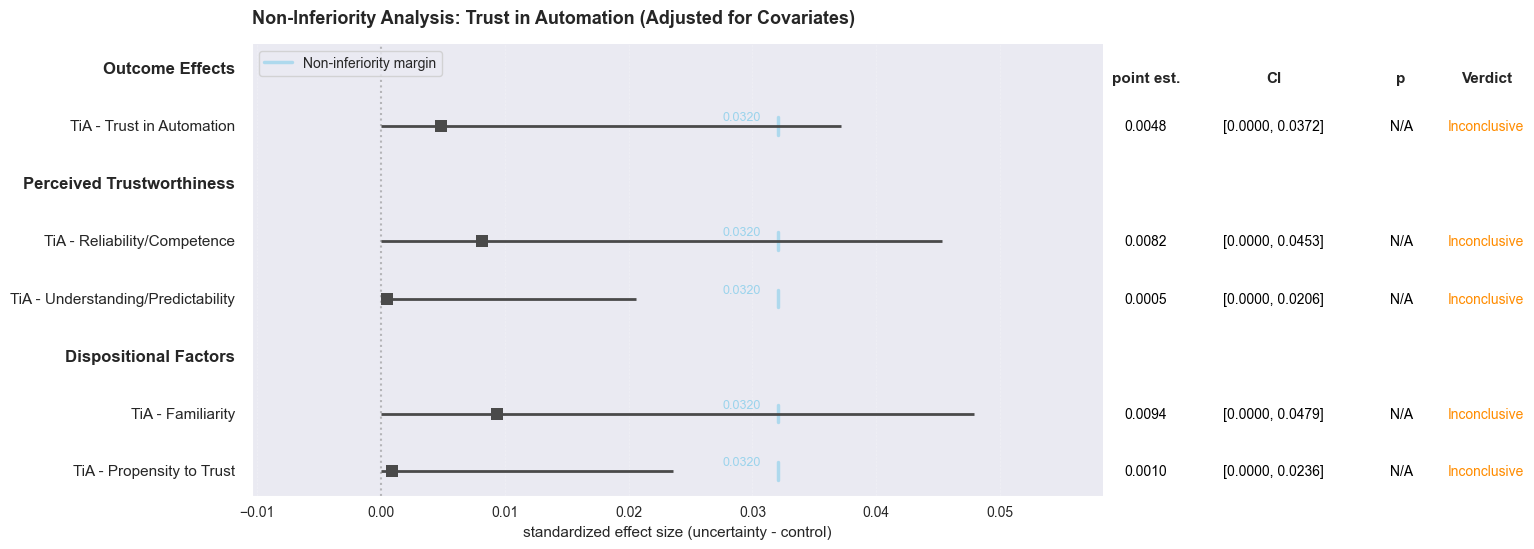

In [104]:
# equivalence test expressed in partial eta squared
df_resids = [model_stats[s]['df_resid'] for s in tia_scales]

eq_margins = [
    convert_to_partial_eta_sq((stats.t.ppf(1 - alpha / 2, df_resid) + stats.t.ppf(power, df_resid)), df_resid)
for df_resid in df_resids]


F_obs = [result_tables[s][result_tables[s]['predictor'] == 'group_effect'].iloc[0]['t'] **2 for s in tia_scales]
coefs_eta = [result_tables[s][result_tables[s]['predictor'] == 'group_effect'].iloc[0]['partial_eta_sq'] for s in tia_scales]

print(F_obs)

cis = [eta_confidence_interval(
    F_obs=F,
    alpha=alpha,
    df1=1,
    df2=df_resid
) for (F, df_resid) in zip(F_obs, df_resids)]

print(cis[0]['eta_sq_upper'])

cis_lower_eta = [cis[i]['eta_sq_lower'] for i in range(len(F_obs))]
cis_upper_eta = [cis[i]['eta_sq_upper'] for i in range(len(F_obs))]

print(cis_lower_eta)
print(cis_upper_eta)

fig, ax = plt.subplots(figsize=(5, 25))
plot_noninferiority_test(
    effect_size=coefs_eta,
    sesoi=eq_margins,
    ci_lower_bounds=cis_lower_eta,  # Pre-computed from F-distribution
    ci_upper_bounds=cis_upper_eta,
    alpha=alpha,
    test_type='upper',
    mode = 'equivalence',
    variable_names=tia_scales,
    variable_labels=scale_titles,
    title='Non-Inferiority Analysis: Trust in Automation (Adjusted for Covariates)',
    xlabel='standardized effect size (partial eta squared)',
    categories=categories,
    category_order=['Outcome Effects', 'Perceived Trustworthiness', 'Dispositional Factors'],
    height_scale=0.7,
    column_title_pos_shift=-0.5,
    ax=ax
)

plt.tight_layout()
plt.savefig(f'{plots_path}univariate_noninferiority_test_standardized.png', dpi=150, transparent=True)
plt.show()